# AFMFIT TUTORIAL version 0.1

## 1. Import the AFM images

The first step is to import the AFM images 

In [1]:
%matplotlib tk
import os
from afmfit.image import ImageSet

# import the example images contained in the tiff
imgs = ImageSet.read_tif(os.getcwd() + "/examples_data/ef2.tiff", vsize=7.0, unit="m")

# displays the images in a separate window
imgs.show()

Read 100 images of size 40 x 40 pix at 0.70 nm/pix 


## 2. Import the PDB

Read the PDB file to be used as initial model 

In [2]:
from afmfit.pdbio import PDB

# read the PDB file
pdb = PDB(os.getcwd() + "/examples_data/ef2.pdb")

# center the atoms around the coordinate 0,0,0
pdb.center()

print("The PDB file contains %i atoms"%pdb.n_atoms)

# Show in ChimeraX (comment this line if Chimerax is not installed)
pdb.viewChimera()

The PDB file contains 6215 atoms


## 4. Calculate NMA

Performs Normal Mode Analysis using NOLB

In [3]:
from afmfit.nma import NormalModesRTB

# Set the desired number of modes and cutoff (in Angstrom) for the elastic network model (higher cutoff= more rigid)
nma = NormalModesRTB.calculate_NMA(pdb,nmodes=3, cutoff=8.0)

# Show in ChimeraX (comment this line if Chimerax is not installed)
# press on the "play" button (bottom right) to diplay the desired mode. Switch between models in the model panel.
nma.viewChimera(amp= 1000)

*******************************************************************
*-----------------------------------------------------------------*
*-----------NOLB : a Non-Linear rigid block NMA method------------*
*----------Authors: Alexandre Hoffmann & Sergei Grudinin----------*
*---------Copyright (c): UGA/CNRS Grenoble, France, 2023.---------*
*-------- e-mail: sergei.grudinin@univ-grenoble-alpes.fr ---------*
*---- http://team.inria.fr/nano-d/software/nolb-normal-modes/ ----*
*-----------------------------------------------------------------*
*******************************************************************
Hostname......................................................... : ljk-ad-77
Run at........................................................... : Wed Jun 12 14:27:01 2024
Command-line arguments........................................... : /home/AD/vuillemr/miniconda/envs/imp/lib/python3.12/site-packages/afmfit/nolb/NOLB /tmp/tmppa8__ugg/.pdb -o /tmp/tmppa8__ugg/ -s 0 -n 3 --format 3 -c

## 5. Set the AFM image simulator

The fitting compares AFM-like images of the initial model to AFM experiments.
This section defines the parameters of the AFM simulator.

In [4]:
%matplotlib tk
from afmfit.simulator import AFMSimulator
from afmfit.viewer import viewAFM

# Set the parameters to simulate the pseudo-AFM images used for the fitting
# Implements eq.1
#  - sigma controls the smoothness
#  - cutoff (angstrom) above which the computation is ignored. Decrease the computational time for smaller values.
#  - beta can be kept to 1.0 (gamma in eq. 1)
simulator = AFMSimulator(size=imgs.size, 
                         vsize=imgs.vsize, 
                         beta=1.0, sigma=3.2, cutoff=40)

# Create an image of the PDB that have been loaded
image = simulator.pdb2afm(pdb)

# show the generated image vs the AFM image
viewAFM([image, imgs.imgs[0]])


(<Figure size 1000x400 with 4 Axes>,
 array([<Axes: xlabel='nm', ylabel='nm'>, <Axes: xlabel='nm', ylabel='nm'>],
       dtype=object))

## 6. Rigid Fitting

The rigid fitting performs a global alignment of the PDB with the images

In [13]:
# import the fitter
from afmfit.fitting import Fitter
import numpy as np

# defines the fitter
fitter = Fitter(pdb=pdb, imgs=imgs.imgs, simulator=simulator)

# Performs the rigid fitting - implements eq.2-5
# - n_cpu : set the number of cpus to use
# - angular_dist :  set the angular increment for the rigid-body search
# - zshift_range : set the translational increment in the z-axis for the rigid body search. Ex : between -20 Ang and 20 Ang with 10 increments
fitter.fit_rigid(n_cpu=16, 
                 angular_dist=10, 
                 verbose=True, 
                 zshift_range=np.linspace(-10,10,5),
                 true_zshift=False)

# save the fitting on the disk
fitter.dump(os.getcwd() +'/examples_data/rigid.pkl')

Projection Matching: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.33it/s]


In [6]:
# reload the fitting if needed
fitter = Fitter.load(os.getcwd() +'/examples_data/rigid.pkl')

# show the results
fitter.show()

## 7. Flexible fitting

Flexibly aligns the model with the images

In [15]:
# Flexible fitting - impelments eq. 9-19
fitter.fit_flexible(n_cpu=16,          # number of CPU
                    nma=nma,           # Normal mode analysis object
                    n_best_views=10,   # Number of rigid views to test as initial pose. 
                    dist_views=15,     # Angular distance (°) between the n_best_views to test.
                    n_iter=10,         # Number of iteration of the algorithm. 10 is typically enough, 
                    lambda_r=20,       # 
                    lambda_f=20, 
                    verbose=True)

fitter.dump(os.getcwd() +'/examples_data/flexible.pkl')

Flexible Fitting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.77s/it]


In [7]:
fitter = Fitter.load(os.getcwd() +'/examples_data/flexible.pkl')

fitter.show()

## 8 Conformational Space with PCA

Calculation fo the conformational space from the fitted models. In this synthetic example, the conformational space describe a circle in the two first normal modes.

/home/AD/vuillemr/miniconda/envs/imp/lib/python3.12/site-packages/afmfit/utils.py:150: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/AD/vuillemr/miniconda/envs/imp/lib/python3.12/site-packages/afmfit/utils.py:128: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


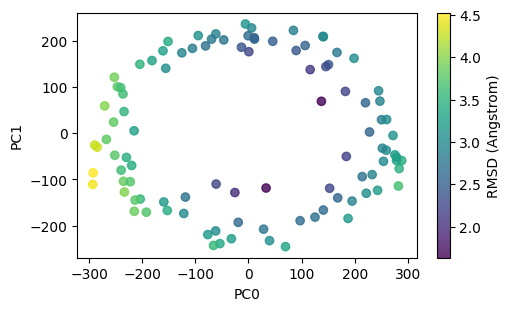

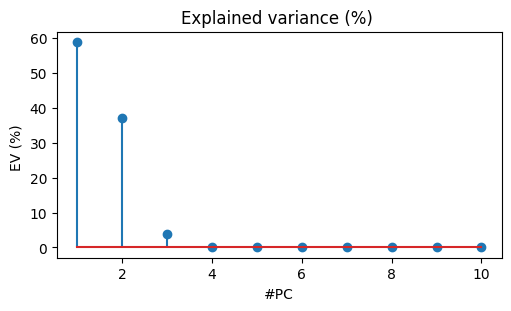

In [9]:
from afmfit.utils import DimRed
%matplotlib inline

pca =DimRed.from_fitter(fitter=fitter, method="pca", n_components=10)

pca.show(ax=[0,1], cval=fitter.get_best_rmsd(), cname="RMSD (Angstrom)" )
pca.show_pca_ev()
#pca.viewAxisChimera(ax=0, avg=True)